<a href="https://colab.research.google.com/github/SachinSouravJha/Machine-Learning-Basics/blob/master/CNN_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from keras.layers import * #Will import all layers
from keras.layers.advanced_activations import LeakyReLU #Variation of relu which returns damped value of x if x si negative
from keras.models import Sequential,Model #Will use sequential again but if we use functional then we will need Model
from keras.optimizers import Adam
from keras.datasets import mnist #The dataset
import matplotlib.pyplot as plt
import math
import numpy as np

Using TensorFlow backend.


In [2]:
(X_Train,_),(_,_) = mnist.load_data()
#We don't need Y here because we will learn ourselves
#Xtest and Ytest will be generated by us


11493376/11490434 [==============================] - 0s 0us/step


In [3]:
print(X_Train.shape)
print(type(X_Train))

X_Train = X_Train.reshape((*(X_Train.shape),1)) #reshaping the data to suit the requirements 
print(X_Train.shape)

(60000, 28, 28)
<class 'numpy.ndarray'>
(60000, 28, 28, 1)


In [4]:
#Normalize the Data between -1 and 1

X_Train = (X_Train.astype('float32') - 127.5)/127.5 #The values will now be between -1 and 1

print(np.min(X_Train)) #The least value
print(np.max(X_Train)) #The maximum value 

-1.0
1.0


In [0]:
NUM_EPOCHS = 50 #Will run 50 times
BATCH_SIZE = 256
NO_OF_BATCHES = math.ceil(X_Train.shape[0]/float(BATCH_SIZE)) #So we will his number of batches
HALF_BATCH_SIZE = int(BATCH_SIZE/2) #Taking half of batch size

NOISE_DIM = 100 #This will be converted to 784 and then will be reshaped to form an image

adam = Adam(lr=2e-4,beta_1=0.5) #The optimizer

In [7]:
#Upsampling 
# Start from 7 X 7 X 128
generator = Sequential()
generator.add(Dense(7*7*128,input_shape=(NOISE_DIM,))) #Taking noise vector and increase it's size
generator.add(Reshape((7,7,128))) #Reshaping it into the given shape
generator.add(LeakyReLU(0.2)) #Applying leaky relu
generator.add(BatchNormalization()) #Will stablize the network and weights

#Double the Activation Size 14 X 14 X 64
generator.add(UpSampling2D())
generator.add(Conv2D(64,kernel_size=(5,5),padding='same')) #Padding ensures that we don't lose any size by doing convolution
generator.add(LeakyReLU(0.2))
generator.add(BatchNormalization())

# Double the Activation Size 28 X 28 X 1
generator.add(UpSampling2D()) #Finally doing 28*28 ensures that image will be generated and spatial 128 ensures that noise will be lesser than MLP model
generator.add(Conv2D(1, kernel_size=(5, 5), padding='same', activation='tanh')) #Final activation

# Final Output (No ReLu or Batch Norm)
generator.compile(loss='binary_crossentropy', optimizer=adam) #Finally compiling 
generator.summary()

#Discriminator - Downsampling
discriminator = Sequential()
discriminator.add(Conv2D(64,(5,5),strides=(2,2),padding='same',input_shape=(28,28,1))) #Number of filters are 64, we are not using max pooling but using 
#strides to reduce to make it 14*14
discriminator.add(LeakyReLU(0.2))

# Prefer Strided Convolutions over MaxPooling
discriminator.add(Conv2D(128,(5,5),strides=(2,2),padding='same')) #128 filters, with 2*2 strides to make it 7*7
discriminator.add(LeakyReLU(0.2))


discriminator.add(Flatten()) #Will then flatten the neurons and then give output
discriminator.add(Dense(1,activation='sigmoid'))

discriminator.compile(loss='binary_crossentropy',optimizer=adam)
discriminator.summary()

#The convuliontal method will work better and we can test it by copying code from MLP

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 6272)              633472    
_________________________________________________________________
reshape_2 (Reshape)          (None, 7, 7, 128)         0         
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
up_sampling2d_3 (UpSampling2 (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        204864    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 14, 14, 64)       

In [0]:
#We don't want to train the discriminator so we put it as false
discriminator.trainable = False
gan_input = Input(shape=(NOISE_DIM,)) #We will generate a random input with size of noise
generated_img = generator(gan_input) #Gan will generate an image accordingly
gan_output = discriminator(generated_img) #

#Functional API
model = Model(gan_input,gan_output)
model.compile(loss='binary_crossentropy',optimizer=adam)

In [0]:
def show_imgs(epoch,samples=100):#Display images
    
    noise = np.random.normal(0,1,size=(samples,NOISE_DIM)) #Will take random input
    generated_imgs = generator.predict(noise) #Will generate image from it
    generated_imgs = generated_imgs.reshape(samples,28,28) #Reshape the images
    
    plt.figure(figsize=(10,10))
    for i in range(samples):
        plt.subplot(10,10,i+1)
        plt.imshow(generated_imgs[i],interpolation='nearest',cmap='gray')
        plt.axis("off")
        
    plt.tight_layout()
    plt.show() #And show them too

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Epoch 1 Disc Loss 0.6847 Generator Loss 0.8697
Epoch 2 Disc Loss 0.6910 Generator Loss 0.8306
Epoch 3 Disc Loss 0.6831 Generator Loss 0.8398
Epoch 4 Disc Loss 0.6869 Generator Loss 0.8265
Epoch 5 Disc Loss 0.6900 Generator Loss 0.8162


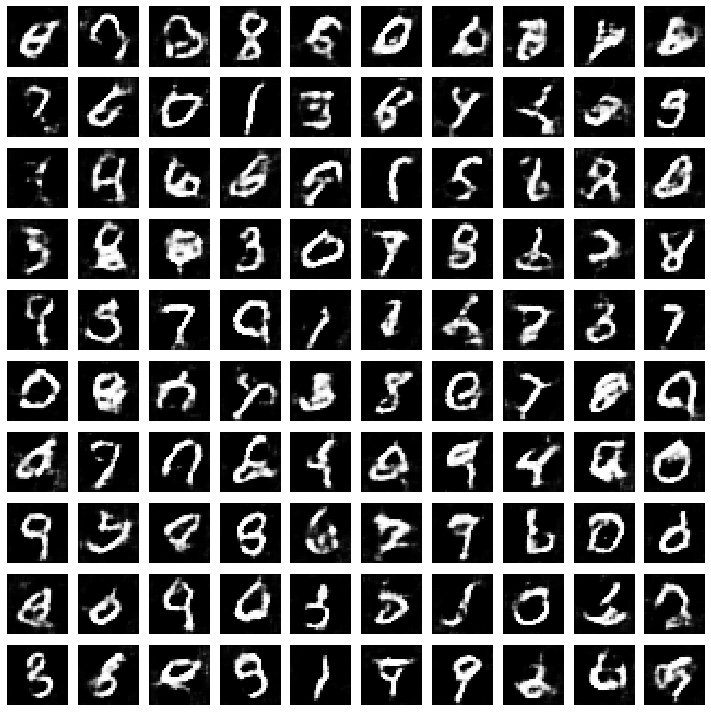

Epoch 6 Disc Loss 0.6895 Generator Loss 0.8199
Epoch 7 Disc Loss 0.6890 Generator Loss 0.8170
Epoch 8 Disc Loss 0.6883 Generator Loss 0.8185
Epoch 9 Disc Loss 0.6877 Generator Loss 0.8173
Epoch 10 Disc Loss 0.6875 Generator Loss 0.8178


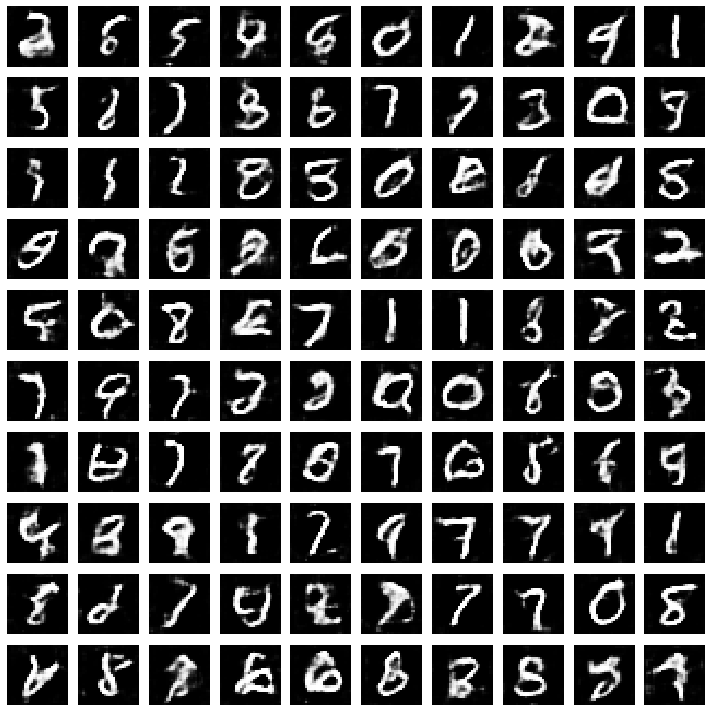

Epoch 11 Disc Loss 0.6866 Generator Loss 0.8233
Epoch 12 Disc Loss 0.6864 Generator Loss 0.8234
Epoch 13 Disc Loss 0.6868 Generator Loss 0.8188
Epoch 14 Disc Loss 0.6855 Generator Loss 0.8252
Epoch 15 Disc Loss 0.6854 Generator Loss 0.8254


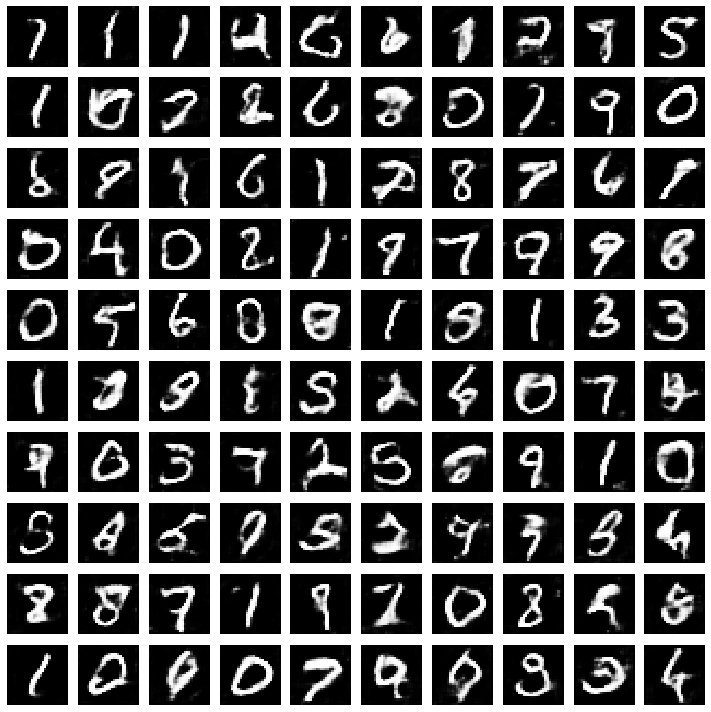

Epoch 16 Disc Loss 0.6848 Generator Loss 0.8270
Epoch 17 Disc Loss 0.6840 Generator Loss 0.8325
Epoch 18 Disc Loss 0.6832 Generator Loss 0.8325
Epoch 19 Disc Loss 0.6833 Generator Loss 0.8301
Epoch 20 Disc Loss 0.6823 Generator Loss 0.8319


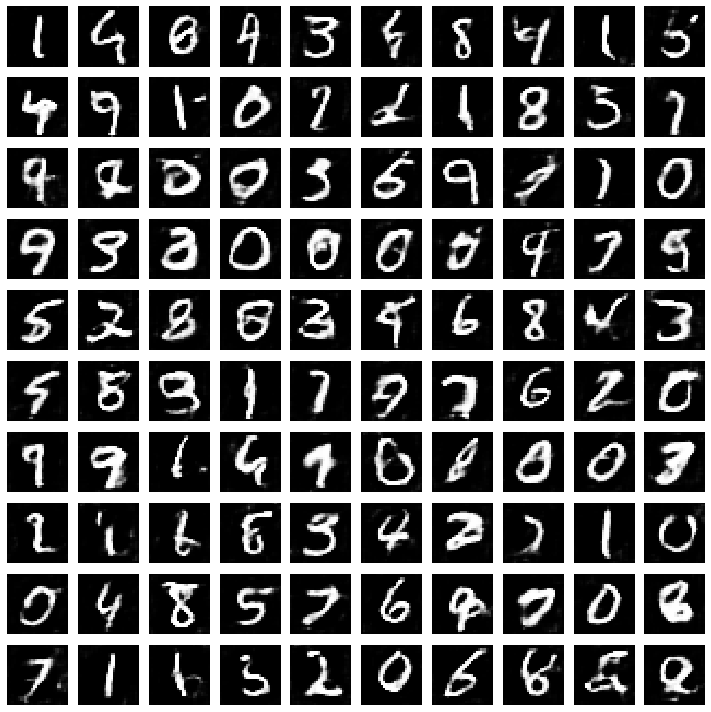

Epoch 21 Disc Loss 0.6807 Generator Loss 0.8456
Epoch 22 Disc Loss 0.6808 Generator Loss 0.8382
Epoch 23 Disc Loss 0.6792 Generator Loss 0.8508
Epoch 24 Disc Loss 0.6792 Generator Loss 0.8455
Epoch 25 Disc Loss 0.6780 Generator Loss 0.8578


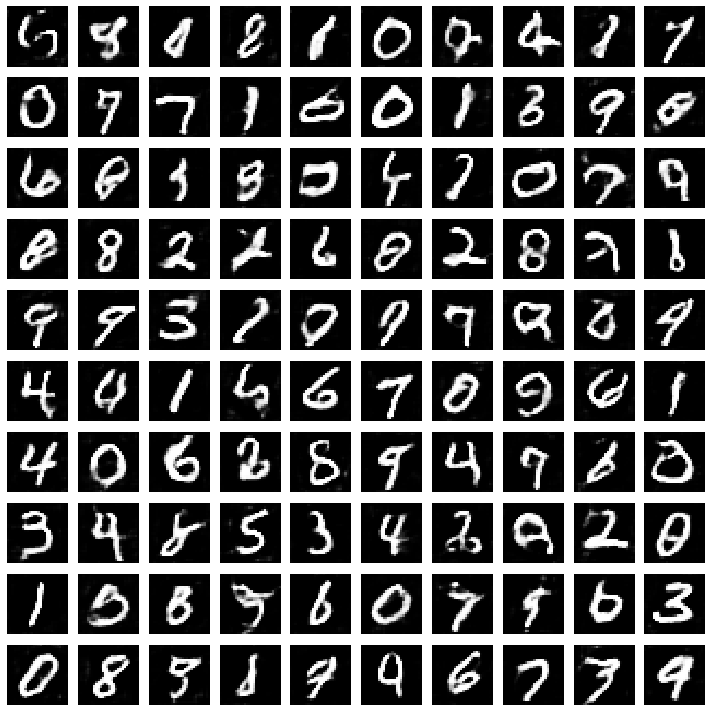

Epoch 26 Disc Loss 0.6768 Generator Loss 0.8529
Epoch 27 Disc Loss 0.6769 Generator Loss 0.8525
Epoch 28 Disc Loss 0.6752 Generator Loss 0.8633
Epoch 29 Disc Loss 0.6747 Generator Loss 0.8618
Epoch 30 Disc Loss 0.6742 Generator Loss 0.8641


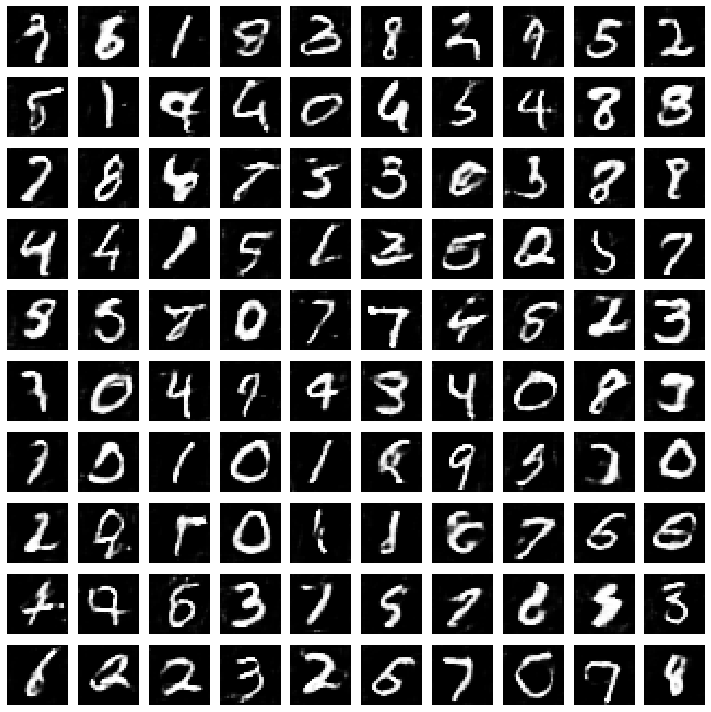

Epoch 31 Disc Loss 0.6728 Generator Loss 0.8717
Epoch 32 Disc Loss 0.6722 Generator Loss 0.8760
Epoch 33 Disc Loss 0.6700 Generator Loss 0.8917
Epoch 34 Disc Loss 0.6706 Generator Loss 0.8786
Epoch 35 Disc Loss 0.6690 Generator Loss 0.8853


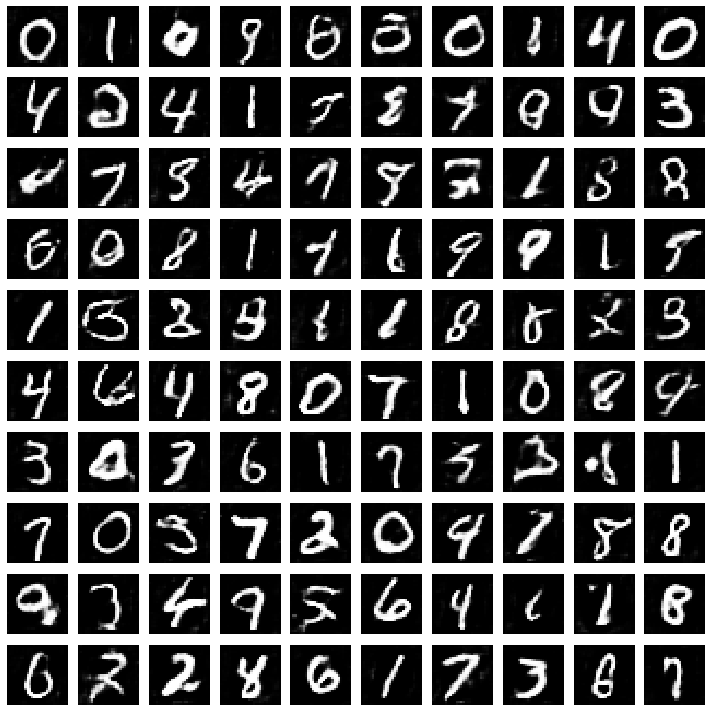

Epoch 36 Disc Loss 0.6684 Generator Loss 0.8911
Epoch 37 Disc Loss 0.6673 Generator Loss 0.8950
Epoch 38 Disc Loss 0.6661 Generator Loss 0.8990
Epoch 39 Disc Loss 0.6651 Generator Loss 0.9015
Epoch 40 Disc Loss 0.6639 Generator Loss 0.9101


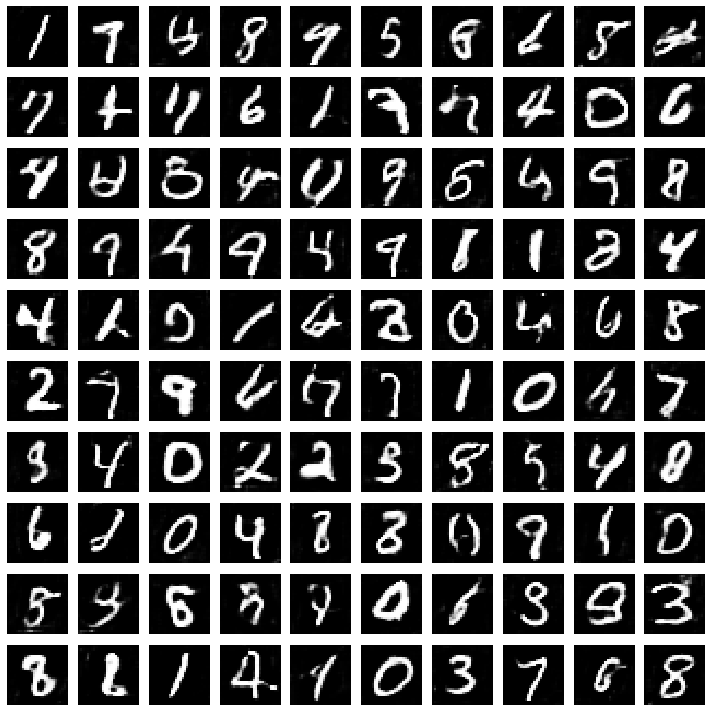

Epoch 41 Disc Loss 0.6631 Generator Loss 0.9129
Epoch 42 Disc Loss 0.6610 Generator Loss 0.9187
Epoch 43 Disc Loss 0.6603 Generator Loss 0.9226
Epoch 44 Disc Loss 0.6591 Generator Loss 0.9290
Epoch 45 Disc Loss 0.6573 Generator Loss 0.9337


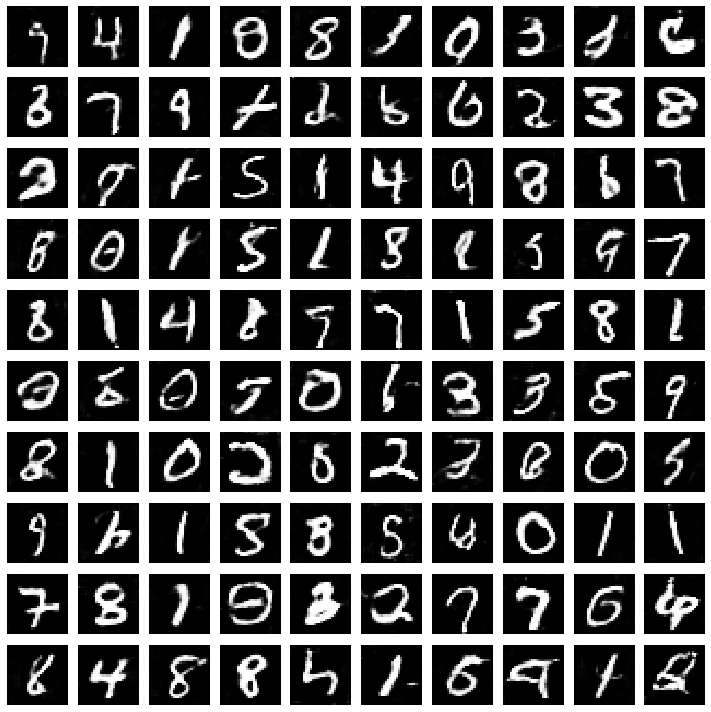

Epoch 46 Disc Loss 0.6563 Generator Loss 0.9368
Epoch 47 Disc Loss 0.6547 Generator Loss 0.9469
Epoch 48 Disc Loss 0.6538 Generator Loss 0.9496
Epoch 49 Disc Loss 0.6524 Generator Loss 0.9571
Epoch 50 Disc Loss 0.6519 Generator Loss 0.9617


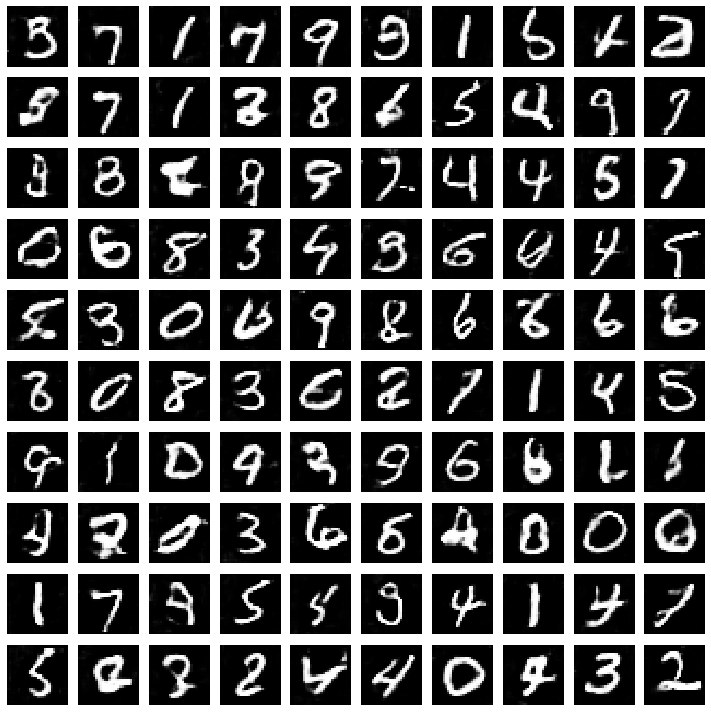

In [10]:
# Training Loop
d_losses = []
g_losses = []

for epoch in range(NUM_EPOCHS):
    epoch_d_loss = 0.
    epoch_g_loss = 0.
    
    for step in range(NO_OF_BATCHES):
        #randomly select 50% real images
        idx = np.random.randint(0,X_Train.shape[0],HALF_BATCH_SIZE) #From a range of 0 to 60,000 it will pick 128 real images
        real_imgs = X_Train[idx]
        
        # generate 50% random images
        noise = np.random.normal(0,1,size=(HALF_BATCH_SIZE,NOISE_DIM)) #Will generate a random image
        fake_imgs = generator.predict(noise)
        
        
        # one sided label smoothing
        real_y = np.ones((HALF_BATCH_SIZE,1))*0.9 #Label Smoothing, Works well in practice
        fake_y = np.zeros((HALF_BATCH_SIZE,1)) #Fake images have zero
        
        # train on real and fake images
        d_loss_real = discriminator.train_on_batch(real_imgs,real_y) #So discriminator will try to give high values for real, but if it fails loss will be high
        d_loss_fake = discriminator.train_on_batch(fake_imgs,fake_y)  #It will try to give low value for fake generated images, so generator will raise its game
        d_loss = 0.5*d_loss_real + 0.5*d_loss_fake #Total loss
        
        epoch_d_loss += d_loss

#Train Generator (Complete Model Generator + Frozen Discriminator)
        noise = np.random.normal(0,1,size=(BATCH_SIZE,NOISE_DIM))
        ground_truth_y = np.ones((BATCH_SIZE,1))
        g_loss = model.train_on_batch(noise,ground_truth_y)
        epoch_g_loss += g_loss
        #We can see that both the losses are stable because generator is getting better at producing images while discriminator is getting better at making fake
    print("Epoch %d Disc Loss %.4f Generator Loss %.4f" %((epoch+1),epoch_d_loss/NO_OF_BATCHES,epoch_g_loss/NO_OF_BATCHES))
    d_losses.append(epoch_d_loss/NO_OF_BATCHES) #Storing all losses of discriminator
    g_losses.append(epoch_g_loss/NO_OF_BATCHES) #Storing all losses of generator
    
    if (epoch+1)%5==0:
      show_imgs(epoch)

#Thanks to increase in spatial area and number of filters we are getting much better quality images in Convolutional GAN than MLP GAN